In [ ]:
!pip install ultralytics --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.7 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import os, shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
!rm -rf /content/drive


In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2) Paths
CSV_PATH      = "/content/drive/MyDrive/data_images/vott-csv-export/sorted_output_file.csv"
IMG_DIR       = "/content/drive/MyDrive/data_images/vott-csv-export"
WORKDIR       = "/content/drive/MyDrive/data_images/yolo_dataset"
TRAIN_IMG_DIR = os.path.join(WORKDIR, "images/train")
VAL_IMG_DIR   = os.path.join(WORKDIR, "images/val")
TRAIN_LBL_DIR = os.path.join(WORKDIR, "labels/train")
VAL_LBL_DIR   = os.path.join(WORKDIR, "labels/val")

In [ ]:
# 3) Create folders
for d in [TRAIN_IMG_DIR, VAL_IMG_DIR, TRAIN_LBL_DIR, VAL_LBL_DIR]:
    os.makedirs(d, exist_ok=True)


In [ ]:
# Load CSV
df = pd.read_csv(CSV_PATH)


In [ ]:
# 5) Build str→int mapping (run once after loading df)
classes = sorted(df['label'].unique())
class_mapping = {c:i for i,c in enumerate(classes)}

In [ ]:
# 6) Converter that uses the mapping (replace your old version)
def convert_to_yolo(row, img_w, img_h):
    xc = (row.xmin + row.xmax) / 2 / img_w
    yc = (row.ymin + row.ymax) / 2 / img_h
    w  = (row.xmax - row.xmin)      / img_w
    h  = (row.ymax - row.ymin)      / img_h
    cls_id = class_mapping[row['label']]    # ← use mapping, not int()
    return f"{cls_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}"

In [ ]:
# 10) Write data.yaml
nc = len(classes)
names = ", ".join(f"'{c}'" for c in classes)
yaml = f"""
path: {WORKDIR}
train: images/train
val:   images/val
nc:    {nc}
names: [{names}]
""".strip()
with open(os.path.join(WORKDIR, 'data.yaml'), 'w') as f:
    f.write(yaml + "\n")

In [ ]:
# 1) Train and capture the Results object

train_results = YOLO('yolov8n.yaml').train(
    data=f"{WORKDIR}/data.yaml",
    epochs=50,
    patience=5,
    imgsz=640,
    batch=16,
    device='cuda',
    name='train_run3'
)

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/data_images/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_run3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, pl

100%|██████████| 755k/755k [00:00<00:00, 99.2MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751507  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLOv8n summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 347MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.3 ms, read: 0.4±0.2 MB/s, size: 363.4 KB)


train: Scanning /content/drive/MyDrive/data_images/yolo_dataset/labels/train.cache... 213 images, 0 backgrounds, 0 corrupt: 100%|██████████| 213/213 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.3±0.2 MB/s, size: 281.5 KB)


val: Scanning /content/drive/MyDrive/data_images/yolo_dataset/labels/val.cache... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<?, ?it/s]


Plotting labels to runs/detect/train_run3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train_run3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       2.2G      5.728      4.434      4.449         43        640: 100%|██████████| 14/14 [00:27<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.21s/it]

                   all         54        450          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.2G      4.302      2.781      3.601         77        640: 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         54        450          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.2G      3.521      2.356      3.056         59        640: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         54        450          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.22G      3.194      2.084       2.59         92        640: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         54        450          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.22G      2.995      1.856      2.302         91        640: 100%|██████████| 14/14 [00:03<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         54        450          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.53G      2.698      1.698      2.062         68        640: 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         54        450          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.55G      2.514      1.556       1.97        127        640: 100%|██████████| 14/14 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         54        450          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.55G      2.427      1.418      1.838         78        640: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         54        450       0.61      0.142      0.228     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.56G      2.269      1.284      1.696         79        640: 100%|██████████| 14/14 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         54        450      0.547      0.391      0.395      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.56G      2.228      1.278       1.71        104        640: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         54        450      0.766      0.667       0.73      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.56G      2.142      1.285      1.624         73        640: 100%|██████████| 14/14 [00:03<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         54        450      0.629      0.621      0.541      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.56G      2.105      1.256      1.623         41        640: 100%|██████████| 14/14 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         54        450      0.833      0.742      0.832      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.56G      2.019      1.137       1.54         70        640: 100%|██████████| 14/14 [00:03<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         54        450      0.804      0.804      0.864      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.56G      1.996       1.08      1.509         77        640: 100%|██████████| 14/14 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         54        450      0.809      0.782      0.844      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.56G      1.953      1.092      1.501         89        640: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         54        450      0.819      0.804      0.871      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.56G      1.925      1.048      1.461         91        640: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         54        450      0.843      0.822      0.897      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.56G      1.901      1.038      1.452         83        640: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         54        450      0.835      0.823      0.891       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.56G      1.908      1.032      1.481         45        640: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         54        450       0.86      0.804      0.893      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.56G      1.922      1.027       1.46         96        640: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         54        450      0.833       0.82      0.866      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.56G      1.872     0.9906      1.432         58        640: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         54        450      0.831      0.853      0.908      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.56G      1.916     0.9928      1.421         84        640: 100%|██████████| 14/14 [00:03<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         54        450      0.785      0.798      0.828      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.56G      1.832     0.9874        1.4         73        640: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         54        450      0.833      0.888      0.924      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.58G      1.873     0.9908      1.444         93        640: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         54        450      0.868      0.847      0.922      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.74G      1.866     0.9585      1.387        100        640: 100%|██████████| 14/14 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         54        450      0.801       0.86      0.858      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.74G      1.823     0.9936      1.413         57        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         54        450      0.848      0.878       0.92      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.76G      1.807     0.9415       1.38         48        640: 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         54        450      0.871      0.836       0.91      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.76G      1.774     0.9265      1.403         89        640: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         54        450      0.878      0.851      0.926      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.78G      1.804     0.9591      1.406         56        640: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         54        450      0.839      0.891      0.923      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.78G      1.773     0.9206      1.344        111        640: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         54        450      0.869      0.856      0.928      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.79G      1.827      0.902      1.384         60        640: 100%|██████████| 14/14 [00:03<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         54        450       0.88      0.891      0.935      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.79G      1.826     0.8978      1.344        101        640: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         54        450      0.864       0.88      0.906      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.79G      1.765     0.8941       1.37         94        640: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         54        450      0.864      0.887      0.931      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.79G      1.777     0.8915      1.334        115        640: 100%|██████████| 14/14 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         54        450       0.89      0.864      0.936      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.79G      1.769     0.8801      1.342         85        640: 100%|██████████| 14/14 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         54        450      0.867       0.84      0.902      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.79G      1.729     0.8735      1.311         89        640: 100%|██████████| 14/14 [00:03<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         54        450       0.91      0.864      0.942       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.79G      1.731     0.8853      1.374         54        640: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         54        450      0.885      0.853      0.932      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.79G      1.741     0.8608      1.354         89        640: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         54        450      0.898      0.865      0.943      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.79G      1.748     0.8826      1.336         32        640: 100%|██████████| 14/14 [00:03<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         54        450       0.88      0.849       0.92      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.79G      1.709     0.8625      1.327         40        640: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         54        450      0.891      0.878      0.939      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.79G      1.762     0.8536      1.344         79        640: 100%|██████████| 14/14 [00:03<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         54        450      0.895      0.869      0.933       0.52


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.79G      1.677     0.9352      1.405         40        640: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         54        450      0.894       0.86       0.93      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.79G      1.671     0.8852      1.363         16        640: 100%|██████████| 14/14 [00:03<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         54        450      0.886      0.864      0.937      0.513
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 37, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



42 epochs completed in 0.083 hours.
Optimizer stripped from runs/detect/train_run3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train_run3/weights/best.pt, 6.2MB

Validating runs/detect/train_run3/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


                   all         54        450      0.898      0.865      0.943      0.526
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train_run3


In [ ]:
import os

for root, dirs, files in os.walk("/content"):
    for file in files:
        if file.endswith(".pt"):
            print(os.path.join(root, file))


/content/yolo11n.pt
/content/runs/detect/train_run3/weights/best.pt
/content/runs/detect/train_run3/weights/last.pt


In [ ]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("/content/runs/detect/train_run3/weights/best.pt")

# Run validation
metrics = model.val()

# Extract metrics
precision = metrics.box.p.item()
recall    = metrics.box.r.item()
f1_score  = metrics.box.f1.item()
map50     = metrics.box.map50.item()
map5095   = metrics.box.map.item()

# Calculate approximate accuracy (optional definition)
accuracy = (precision + recall) / 2

# Display results
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall    * 100:.2f}%")
print(f"F1 Score:  {f1_score  * 100:.2f}%")
print(f"mAP@0.5:   {map50 * 100:.2f}%")
print(f"mAP@0.5:0.95: {map5095 * 100:.2f}%")
print(f"Approx. Accuracy: {accuracy * 100:.2f}%")



Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 140.2±71.0 MB/s, size: 311.2 KB)


val: Scanning /content/drive/MyDrive/data_images/yolo_dataset/labels/val.cache... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


                   all         54        450      0.898      0.865      0.943      0.527
Speed: 13.3ms preprocess, 11.9ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/detect/val
Precision: 89.84%
Recall:    86.51%
F1 Score:  88.14%
mAP@0.5:   94.28%
mAP@0.5:0.95: 52.71%
Approx. Accuracy: 88.18%


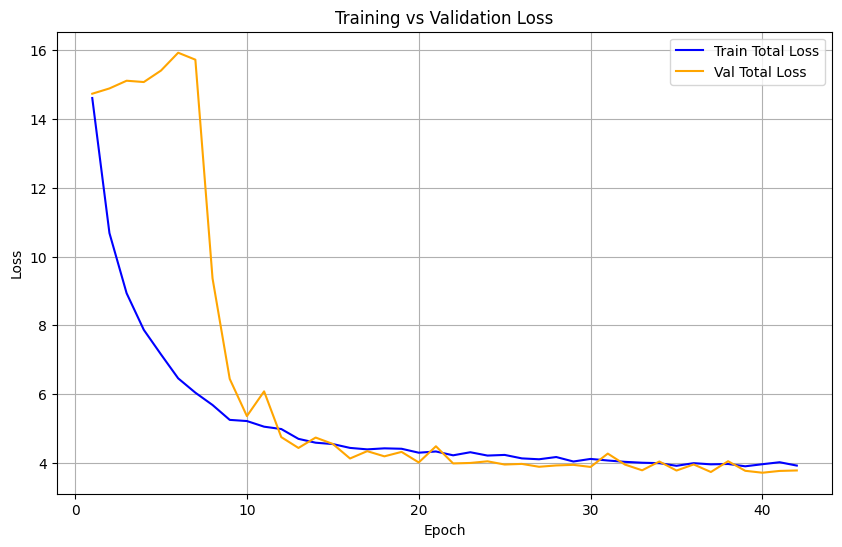

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results
df = pd.read_csv("/content/runs/detect/train_run3/results.csv")

# Compute total losses
df['train_total_loss'] = df['train/box_loss'] + df['train/cls_loss'] + df['train/dfl_loss']
df['val_total_loss'] = df['val/box_loss'] + df['val/cls_loss'] + df['val/dfl_loss']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train_total_loss'], label='Train Total Loss', color='blue')
plt.plot(df['epoch'], df['val_total_loss'], label='Val Total Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from ultralytics import YOLO
import pandas as pd
import os
from glob import glob
from tqdm import tqdm

# Load the trained YOLO model (adjust the path to your trained weights)
model = YOLO('/content/runs/detect/train_run3/weights/best.pt')  # Change this path if needed

# Path to the images you want to run inference on
image_folder = '/content/drive/MyDrive/data_images/yolo_dataset/images/train'  # Change this to your actual image directory
image_paths = sorted(glob(os.path.join(image_folder, '*.jpg')))  # Use '*.png' or '*.tif' if needed

# Store detection results
results_list = []

# Run inference on all images
for image_path in tqdm(image_paths, desc="Running inference"):
    image_name = os.path.basename(image_path)

    # Run model
    results = model(image_path)[0]  # First result object

    # Extract bounding boxes: [xmin, ymin, xmax, ymax, confidence, class]
    for box in results.boxes.data.tolist():
        xmin, ymin, xmax, ymax, conf, cls = box
        results_list.append({
            'image': image_name,
            'class_id': int(cls),
            'confidence': round(conf, 4),
            'xmin': int(xmin),
            'ymin': int(ymin),
            'xmax': int(xmax),
            'ymax': int(ymax)
        })

# Convert to a DataFrame
df = pd.DataFrame(results_list)

# Save to CSV
output_csv = '/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_train_predictions1.csv'
df.to_csv(output_csv, index=False)

print(f"Saved results to {output_csv}")


Running inference:   0%|          | 0/213 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_1.jpg: 384x640 4 sperms, 35.8ms
Speed: 2.4ms preprocess, 35.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Running inference:   0%|          | 1/213 [00:00<00:39,  5.36it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_10.jpg: 384x640 20 sperms, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_101.jpg: 384x640 3 sperms, 28.2ms
Speed: 4.7ms preprocess, 28.2ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:   1%|▏         | 3/213 [00:00<00:18, 11.60it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_102.jpg: 384x640 4 sperms, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_103.jpg: 384x640 3 sperms, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Running inference:   2%|▏         | 5/213 [00:00<00:28,  7.37it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_106.jpg: 384x640 10 sperms, 10.9ms
Speed: 3.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_107.jpg: 384x640 10 sperms, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_109.jpg: 384x640 6 sperms, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_11.jpg: 384x640 24 sperms, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:   4%|▍         | 9/213 [00:00<00:14, 13.80it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_110.jpg: 384x640 4 sperms, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_111.jpg: 384x640 4 sperms, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_112.jpg: 384x640 6 sperms, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_114.jpg: 384x640 10 sperms, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:   6%|▌         | 13/213 [00:00<00:10, 19.40it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_116.jpg: 384x640 12 sperms, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_118.jpg: 384x640 9 sperms, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_120.jpg: 384x640 10 sperms, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_126.jpg: 384x640 8 sperms, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:   8%|▊         | 17/213 [00:00<00:08, 23.44it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_127.jpg: 384x640 12 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_128.jpg: 384x640 6 sperms, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_130.jpg: 384x640 1 sperm, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_131.jpg: 384x640 6 sperms, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  10%|▉         | 21/213 [00:01<00:07, 26.80it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_132.jpg: 384x640 5 sperms, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_133.jpg: 384x640 8 sperms, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_134.jpg: 384x640 10 sperms, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_135.jpg: 384x640 4 sperms, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  12%|█▏        | 25/213 [00:01<00:06, 29.82it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_136.jpg: 384x640 10 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_137.jpg: 384x640 6 sperms, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_138.jpg: 384x640 6 sperms, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_139.jpg: 384x640 6 sperms, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  14%|█▎        | 29/213 [00:01<00:05, 32.27it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_14.jpg: 384x640 63 sperms, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_140.jpg: 384x640 2 sperms, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_141.jpg: 384x640 1 sperm, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_142.jpg: 384x640 5 sperms, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  15%|█▌        | 33/213 [00:01<00:05, 33.34it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_143.jpg: 384x640 7 sperms, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_145.jpg: 384x640 11 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_146.jpg: 384x640 9 sperms, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_147.jpg: 384x640 14 sperms, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  17%|█▋        | 37/213 [00:01<00:05, 34.50it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_149.jpg: 384x640 6 sperms, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_15.jpg: 384x640 32 sperms, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_150.jpg: 384x640 9 sperms, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_151.jpg: 384x640 5 sperms, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  19%|█▉        | 41/213 [00:01<00:04, 34.79it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_152.jpg: 384x640 8 sperms, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_154.jpg: 384x640 13 sperms, 13.5ms
Speed: 3.3ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_155.jpg: 384x640 6 sperms, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_156.jpg: 384x640 12 sperms, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  21%|██        | 45/213 [00:01<00:05, 32.72it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_158.jpg: 384x640 11 sperms, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_16.jpg: 384x640 38 sperms, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_160.jpg: 384x640 9 sperms, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_161.jpg: 384x640 8 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  23%|██▎       | 49/213 [00:01<00:05, 32.65it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_162.jpg: 384x640 7 sperms, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_163.jpg: 384x640 3 sperms, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_164.jpg: 384x640 8 sperms, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_165.jpg: 384x640 9 sperms, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  25%|██▍       | 53/213 [00:02<00:04, 32.72it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_166.jpg: 384x640 6 sperms, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_167.jpg: 384x640 8 sperms, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_168.jpg: 384x640 10 sperms, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_17.jpg: 384x640 30 sperms, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  27%|██▋       | 57/213 [00:02<00:04, 33.18it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_170.jpg: 384x640 6 sperms, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_171.jpg: 384x640 7 sperms, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_172.jpg: 384x640 8 sperms, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_174.jpg: 384x640 4 sperms, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  29%|██▊       | 61/213 [00:02<00:04, 33.89it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_175.jpg: 384x640 9 sperms, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_176.jpg: 384x640 9 sperms, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_177.jpg: 384x640 10 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_178.jpg: 384x640 (no detections), 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  31%|███       | 65/213 [00:02<00:04, 33.29it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_179.jpg: 384x640 6 sperms, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_182.jpg: 384x640 3 sperms, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_183.jpg: 384x640 2 sperms, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_185.jpg: 384x640 3 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  32%|███▏      | 69/213 [00:02<00:04, 33.94it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_187.jpg: 384x640 4 sperms, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_188.jpg: 384x640 5 sperms, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_189.jpg: 384x640 4 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_191.jpg: 384x640 2 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  34%|███▍      | 73/213 [00:02<00:04, 34.62it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_192.jpg: 384x640 3 sperms, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_193.jpg: 384x640 1 sperm, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_196.jpg: 384x640 1 sperm, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_198.jpg: 384x640 1 sperm, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  36%|███▌      | 77/213 [00:02<00:03, 34.16it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_2.jpg: 384x640 1 sperm, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_20.jpg: 384x640 39 sperms, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_201.jpg: 384x640 2 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_202.jpg: 384x640 1 sperm, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  38%|███▊      | 81/213 [00:02<00:03, 33.92it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_205.jpg: 384x640 4 sperms, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_206.jpg: 384x640 4 sperms, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_209.jpg: 384x640 2 sperms, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_21.jpg: 384x640 28 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  40%|███▉      | 85/213 [00:02<00:03, 34.27it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_211.jpg: 384x640 2 sperms, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_212.jpg: 384x640 2 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_213.jpg: 384x640 1 sperm, 7.1ms
Speed: 5.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_218.jpg: 384x640 1 sperm, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  42%|████▏     | 89/213 [00:03<00:03, 33.64it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_220.jpg: 384x640 2 sperms, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_221.jpg: 384x640 4 sperms, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_223.jpg: 384x640 1 sperm, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_224.jpg: 384x640 2 sperms, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  44%|████▎     | 93/213 [00:03<00:03, 33.58it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_225.jpg: 384x640 1 sperm, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_227.jpg: 384x640 (no detections), 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_228.jpg: 384x640 4 sperms, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_23.jpg: 384x640 5 sperms, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  46%|████▌     | 97/213 [00:03<00:03, 33.42it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_232.jpg: 384x640 1 sperm, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_233.jpg: 384x640 1 sperm, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_236.jpg: 384x640 1 sperm, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_237.jpg: 384x640 5 sperms, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  47%|████▋     | 101/213 [00:03<00:03, 33.41it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_24.jpg: 384x640 23 sperms, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_245.jpg: 384x640 1 sperm, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_246.jpg: 384x640 4 sperms, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_248.jpg: 384x640 2 sperms, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  49%|████▉     | 105/213 [00:03<00:03, 34.42it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_249.jpg: 384x640 2 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_25.jpg: 384x640 17 sperms, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_250.jpg: 384x640 5 sperms, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_252.jpg: 384x640 3 sperms, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  51%|█████     | 109/213 [00:03<00:02, 34.95it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_253.jpg: 384x640 2 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_254.jpg: 384x640 2 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_256.jpg: 384x640 6 sperms, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_26.jpg: 384x640 13 sperms, 13.6ms
Speed: 3.1ms preprocess, 13.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  53%|█████▎    | 113/213 [00:03<00:02, 33.40it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_260.jpg: 384x640 3 sperms, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_262.jpg: 384x640 4 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_264.jpg: 384x640 3 sperms, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_265.jpg: 384x640 5 sperms, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  55%|█████▍    | 117/213 [00:03<00:02, 33.43it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_267.jpg: 384x640 4 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_269.jpg: 384x640 4 sperms, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_270.jpg: 384x640 6 sperms, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_271.jpg: 384x640 3 sperms, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  57%|█████▋    | 121/213 [00:04<00:02, 33.11it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_272.jpg: 384x640 7 sperms, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_273.jpg: 384x640 3 sperms, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_274.jpg: 384x640 6 sperms, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_277.jpg: 384x640 10 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  59%|█████▊    | 125/213 [00:04<00:02, 34.22it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_278.jpg: 384x640 15 sperms, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_28.jpg: 384x640 15 sperms, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_280.jpg: 384x640 7 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_281.jpg: 384x640 6 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  61%|██████    | 129/213 [00:04<00:02, 34.89it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_282.jpg: 384x640 10 sperms, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_283.jpg: 384x640 1 sperm, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_284.jpg: 384x640 2 sperms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_285.jpg: 384x640 4 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  62%|██████▏   | 133/213 [00:04<00:02, 34.78it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_286.jpg: 384x640 5 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_288.jpg: 384x640 9 sperms, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_289.jpg: 384x640 10 sperms, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_29.jpg: 384x640 18 sperms, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  64%|██████▍   | 137/213 [00:04<00:02, 33.69it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_290.jpg: 384x640 2 sperms, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_291.jpg: 384x640 13 sperms, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_292.jpg: 384x640 11 sperms, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_294.jpg: 384x640 7 sperms, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  66%|██████▌   | 141/213 [00:04<00:02, 34.31it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_295.jpg: 384x640 6 sperms, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_297.jpg: 384x640 8 sperms, 11.5ms
Speed: 3.3ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_298.jpg: 384x640 5 sperms, 12.4ms
Speed: 3.8ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_3.jpg: 384x640 1 sperm, 11.2ms
Speed: 3.4ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  68%|██████▊   | 145/213 [00:04<00:02, 31.54it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_30.jpg: 384x640 24 sperms, 15.9ms
Speed: 3.1ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_300.jpg: 384x640 6 sperms, 12.8ms
Speed: 7.2ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_301.jpg: 384x640 5 sperms, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_302.jpg: 384x640 6 sperms, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  70%|██████▉   | 149/213 [00:04<00:02, 28.35it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_303.jpg: 384x640 24 sperms, 12.6ms
Speed: 5.7ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_304.jpg: 384x640 16 sperms, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_305.jpg: 384x640 33 sperms, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  71%|███████▏  | 152/213 [00:05<00:02, 28.10it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_31.jpg: 384x640 9 sperms, 12.3ms
Speed: 5.0ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_32.jpg: 384x640 23 sperms, 8.1ms
Speed: 4.4ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_34.jpg: 384x640 9 sperms, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  73%|███████▎  | 155/213 [00:05<00:02, 27.88it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_35.jpg: 384x640 29 sperms, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_37.jpg: 384x640 15 sperms, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_38.jpg: 384x640 11 sperms, 14.3ms
Speed: 5.3ms preprocess, 14.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  74%|███████▍  | 158/213 [00:05<00:02, 27.04it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_39.jpg: 384x640 13 sperms, 14.2ms
Speed: 3.4ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_40.jpg: 384x640 24 sperms, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_41.jpg: 384x640 29 sperms, 10.4ms
Speed: 3.1ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  76%|███████▌  | 161/213 [00:05<00:01, 26.34it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_42.jpg: 384x640 23 sperms, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_43.jpg: 384x640 35 sperms, 13.3ms
Speed: 2.4ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_44.jpg: 384x640 21 sperms, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  77%|███████▋  | 164/213 [00:05<00:01, 26.10it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_45.jpg: 384x640 24 sperms, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_46.jpg: 384x640 31 sperms, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_47.jpg: 384x640 43 sperms, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  78%|███████▊  | 167/213 [00:05<00:01, 26.41it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_50.jpg: 384x640 9 sperms, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_51.jpg: 384x640 12 sperms, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_52.jpg: 384x640 13 sperms, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  80%|███████▉  | 170/213 [00:05<00:01, 26.10it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_53.jpg: 384x640 11 sperms, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_54.jpg: 384x640 9 sperms, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_55.jpg: 384x640 12 sperms, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  81%|████████  | 173/213 [00:05<00:01, 25.99it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_56.jpg: 384x640 8 sperms, 10.4ms
Speed: 4.0ms preprocess, 10.4ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_57.jpg: 384x640 10 sperms, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_58.jpg: 384x640 9 sperms, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  83%|████████▎ | 176/213 [00:05<00:01, 24.67it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_59.jpg: 384x640 13 sperms, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_6.jpg: 384x640 4 sperms, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_60.jpg: 384x640 7 sperms, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  84%|████████▍ | 179/213 [00:06<00:01, 25.69it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_61.jpg: 384x640 20 sperms, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_62.jpg: 384x640 11 sperms, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_64.jpg: 384x640 11 sperms, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  85%|████████▌ | 182/213 [00:06<00:01, 26.62it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_65.jpg: 384x640 10 sperms, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_66.jpg: 384x640 11 sperms, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_67.jpg: 384x640 12 sperms, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  87%|████████▋ | 185/213 [00:06<00:01, 27.23it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_68.jpg: 384x640 13 sperms, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_7.jpg: 384x640 1 sperm, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_70.jpg: 384x640 7 sperms, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  88%|████████▊ | 188/213 [00:06<00:00, 27.46it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_71.jpg: 384x640 10 sperms, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_72.jpg: 384x640 9 sperms, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_73.jpg: 384x640 9 sperms, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  90%|████████▉ | 191/213 [00:06<00:00, 26.55it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_74.jpg: 384x640 7 sperms, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_75.jpg: 384x640 5 sperms, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_77.jpg: 384x640 5 sperms, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  91%|█████████ | 194/213 [00:06<00:00, 25.82it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_79.jpg: 384x640 11 sperms, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_8.jpg: 384x640 3 sperms, 8.6ms
Speed: 3.8ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_80.jpg: 384x640 7 sperms, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  92%|█████████▏| 197/213 [00:06<00:00, 25.72it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_81.jpg: 384x640 18 sperms, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_82.jpg: 384x640 7 sperms, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_83.jpg: 384x640 10 sperms, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  94%|█████████▍| 200/213 [00:06<00:00, 26.11it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_84.jpg: 384x640 4 sperms, 9.2ms
Speed: 5.6ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_86.jpg: 384x640 4 sperms, 12.9ms
Speed: 3.2ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_88.jpg: 384x640 10 sperms, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  95%|█████████▌| 203/213 [00:07<00:00, 25.55it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_89.jpg: 384x640 1 sperm, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_90.jpg: 384x640 2 sperms, 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_91.jpg: 384x640 5 sperms, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  97%|█████████▋| 206/213 [00:07<00:00, 26.67it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_92.jpg: 384x640 5 sperms, 9.3ms
Speed: 5.2ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_93.jpg: 384x640 2 sperms, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_94.jpg: 384x640 5 sperms, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  98%|█████████▊| 209/213 [00:07<00:00, 26.97it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_96.jpg: 384x640 5 sperms, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_97.jpg: 384x640 2 sperms, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_98.jpg: 384x640 2 sperms, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Running inference: 100%|█████████▉| 212/213 [00:07<00:00, 27.36it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/train/image_99.jpg: 384x640 4 sperms, 8.2ms
Speed: 3.8ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Running inference: 100%|██████████| 213/213 [00:07<00:00, 28.91it/s]

Saved results to /content/drive/MyDrive/data_images/yolo_dataset/images/yolo_train_predictions1.csv


In [ ]:
from ultralytics import YOLO
import pandas as pd
import os
from glob import glob
from tqdm import tqdm

# Load the trained YOLO model (adjust the path to your trained weights)
model = YOLO('/content/runs/detect/train_run3/weights/best.pt')  # Change this path if needed

# Path to the images you want to run inference on
image_folder = '/content/drive/MyDrive/data_images/yolo_dataset/images/val'  # Change this to your actual image directory
image_paths = sorted(glob(os.path.join(image_folder, '*.jpg')))  # Use '*.png' or '*.tif' if needed

# Store detection results
results_list = []

# Run inference on all images
for image_path in tqdm(image_paths, desc="Running inference"):
    image_name = os.path.basename(image_path)

    # Run model
    results = model(image_path)[0]  # First result object

    # Extract bounding boxes: [xmin, ymin, xmax, ymax, confidence, class]
    for box in results.boxes.data.tolist():
        xmin, ymin, xmax, ymax, conf, cls = box
        results_list.append({
            'image': image_name,
            'class_id': int(cls),
            'confidence': round(conf, 4),
            'xmin': int(xmin),
            'ymin': int(ymin),
            'xmax': int(xmax),
            'ymax': int(ymax)
        })

# Convert to a DataFrame
df = pd.DataFrame(results_list)

# Save to CSV
output_csv = '/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_val_predictions1.csv'
df.to_csv(output_csv, index=False)

print(f"Saved results to {output_csv}")


Running inference:   0%|          | 0/54 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_100.jpg: 384x640 6 sperms, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:   2%|▏         | 1/54 [00:00<00:05,  9.05it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_104.jpg: 384x640 4 sperms, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_108.jpg: 384x640 3 sperms, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_113.jpg: 384x640 4 sperms, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_115.jpg: 384x640 14 sperms, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:   9%|▉         | 5/54 [00:00<00:01, 25.44it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_117.jpg: 384x640 3 sperms, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_119.jpg: 384x640 7 sperms, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_12.jpg: 384x640 24 sperms, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_121.jpg: 384x640 6 sperms, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  17%|█▋        | 9/54 [00:00<00:01, 30.57it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_122.jpg: 384x640 5 sperms, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_123.jpg: 384x640 7 sperms, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_125.jpg: 384x640 8 sperms, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_129.jpg: 384x640 4 sperms, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  24%|██▍       | 13/54 [00:00<00:01, 31.51it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_13.jpg: 384x640 47 sperms, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_144.jpg: 384x640 8 sperms, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_148.jpg: 384x640 6 sperms, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_153.jpg: 384x640 9 sperms, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  31%|███▏      | 17/54 [00:00<00:01, 32.22it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_157.jpg: 384x640 8 sperms, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_159.jpg: 384x640 8 sperms, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_169.jpg: 384x640 12 sperms, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_173.jpg: 384x640 5 sperms, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  39%|███▉      | 21/54 [00:00<00:01, 32.53it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_18.jpg: 384x640 25 sperms, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_184.jpg: 384x640 2 sperms, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_186.jpg: 384x640 5 sperms, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_19.jpg: 384x640 36 sperms, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  46%|████▋     | 25/54 [00:00<00:00, 32.95it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_190.jpg: 384x640 1 sperm, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_207.jpg: 384x640 2 sperms, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_210.jpg: 384x640 7 sperms, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_219.jpg: 384x640 2 sperms, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  54%|█████▎    | 29/54 [00:00<00:00, 33.28it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_22.jpg: 384x640 11 sperms, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_240.jpg: 384x640 3 sperms, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_247.jpg: 384x640 1 sperm, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_255.jpg: 384x640 3 sperms, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  61%|██████    | 33/54 [00:01<00:00, 33.12it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_257.jpg: 384x640 1 sperm, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_27.jpg: 384x640 19 sperms, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_275.jpg: 384x640 11 sperms, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_276.jpg: 384x640 14 sperms, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  69%|██████▊   | 37/54 [00:01<00:00, 33.84it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_279.jpg: 384x640 10 sperms, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_287.jpg: 384x640 2 sperms, 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_293.jpg: 384x640 12 sperms, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_296.jpg: 384x640 7 sperms, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  76%|███████▌  | 41/54 [00:01<00:00, 32.88it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_299.jpg: 384x640 14 sperms, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_33.jpg: 384x640 18 sperms, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_36.jpg: 384x640 14 sperms, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_48.jpg: 384x640 5 sperms, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  83%|████████▎ | 45/54 [00:01<00:00, 33.54it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_49.jpg: 384x640 11 sperms, 14.3ms
Speed: 3.4ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_63.jpg: 384x640 21 sperms, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_69.jpg: 384x640 9 sperms, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_76.jpg: 384x640 5 sperms, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  91%|█████████ | 49/54 [00:01<00:00, 32.46it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_78.jpg: 384x640 10 sperms, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_85.jpg: 384x640 1 sperm, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_87.jpg: 384x640 4 sperms, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_9.jpg: 384x640 2 sperms, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running inference:  98%|█████████▊| 53/54 [00:01<00:00, 32.68it/s]


image 1/1 /content/drive/MyDrive/data_images/yolo_dataset/images/val/image_95.jpg: 384x640 9 sperms, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running inference: 100%|██████████| 54/54 [00:01<00:00, 32.02it/s]

Saved results to /content/drive/MyDrive/data_images/yolo_dataset/images/yolo_val_predictions1.csv


In [ ]:
import pandas as pd

# Paths to the CSV files
csv_file_1 = '/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_train_predictions1.csv'
csv_file_2 = '/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_val_predictions1.csv'

# Read both CSV files
df1 = pd.read_csv(csv_file_1)
df2 = pd.read_csv(csv_file_2)

# Merge the two DataFrames
merged_df = pd.concat([df1, df2], ignore_index=True)

# Optional: Drop duplicate rows (if needed)
# merged_df = merged_df.drop_duplicates()

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('/content/drive/MyDrive/data_images/yolo_dataset/images/merged_file.csv', index=False)

print("✅ Files successfully merged and saved as 'merged_file.csv'")


✅ Files successfully merged and saved as 'merged_file.csv'


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7e0hpkmc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7e0hpkmc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=d8b059d43b58658eeeda4e4a7f24c1958d8747eebc98408c14557b0462db7027
  Stored in directory: /tmp/pip-ephem-wheel-cache-ah1r3grp/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth


--2025-05-26 07:44:42--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.121, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.pth       100%[===================>] 357.67M   129MB/s    in 2.8s    

2025-05-26 07:44:45 (129 MB/s) - ‘sam_vit_b.pth’ saved [375042383/375042383]



In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from segment_anything import sam_model_registry, SamPredictor
from torchvision.ops import masks_to_boxes

In [ ]:
# --- Configuration ---
yolo_csv_path = "/content/drive/MyDrive/data_images/yolo_dataset/images/merged_file.csv"             # Input CSV from YOLO
images_dir = "/content/drive/MyDrive/data_images/vott-csv-export"                         # Directory containing images
sam_model_type = "vit_b"
sam_checkpoint_path = "/content/sam_vit_b.pth"
output_csv_path = "/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_sam_output.csv"


In [ ]:
# --- Load SAM ---
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[sam_model_type](checkpoint=sam_checkpoint_path)
sam.to(device)
predictor = SamPredictor(sam)


In [ ]:
# --- Load YOLO CSV ---
df = pd.read_csv(yolo_csv_path)

In [ ]:
from PIL import Image


In [ ]:
output_rows = []

# Get unique image names from the input dataframe
unique_images = df['image'].unique().tolist()

for image_name in tqdm(unique_images):
    image_path = os.path.join(images_dir, image_name)
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    predictor.set_image(image_np)

    # Filter rows for current image
    image_rows = df[df['image'] == image_name]

    for _, row in image_rows.iterrows():
        # Extract bounding box coordinates in [xmin, ymin, xmax, ymax]
        box = np.array([row['xmin'], row['ymin'], row['xmax'], row['ymax']])

        # Run SAM prediction with box prompt
        masks, scores, _ = predictor.predict(box=box[None, :], multimask_output=True)
        best_mask = masks[np.argmax(scores)]

        # Convert the mask to bounding box
        boxes = masks_to_boxes(torch.tensor(best_mask[None, :, :]))[0].int().tolist()
        xmin, ymin, xmax, ymax = boxes

        output_rows.append({
            "image": image_name,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax,
            "score": float(scores[np.argmax(scores)])
        })

# Save the results as a CSV
output_df = pd.DataFrame(output_rows)
output_df.to_csv(output_csv, index=False)

print("✅ Saved SAM-generated boxes to:", output_csv)


100%|██████████| 265/265 [06:51<00:00,  1.55s/it]

✅ Saved SAM-generated boxes to: /content/drive/MyDrive/data_images/yolo_dataset/images/yolo_val_predictions1.csv


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_val_predictions.csv')

# Calculate area of each box
df['area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])

# Compute average area
average_area = df['area'].mean()

print(f"Average box area: {average_area}")


Average box area: 14501.408080808082


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_val_predictions.csv')

# Calculate the area of each box
df['area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])

# Set a threshold for minimum box area
threshold = 6000  # You can change this value

# Filter boxes based on area
filtered_df = df[df['area'] >= threshold].drop(columns='area')

# Save the filtered boxes to a new CSV
filtered_df.to_csv('filtered_boxes.csv', index=False)

# Show the result
print(filtered_df)


             image  class_id  confidence  xmin  ymin  xmax  ymax
0    image_100.jpg         0      0.7314   205   222   317   365
1    image_100.jpg         0      0.6827  1040   211  1169   313
2    image_100.jpg         0      0.6467   530   147   645   262
3    image_100.jpg         0      0.5907   497     0   624   152
4    image_100.jpg         0      0.5547   704   839   858   944
..             ...       ...         ...   ...   ...   ...   ...
488   image_95.jpg         0      0.7402   694   257   806   394
489   image_95.jpg         0      0.6137  1087   866  1223   986
490   image_95.jpg         0      0.4278  1175   326  1279   460
491   image_95.jpg         0      0.3605  1299   503  1398   592
492   image_95.jpg         0      0.3455  1157   463  1307   626

[482 rows x 7 columns]


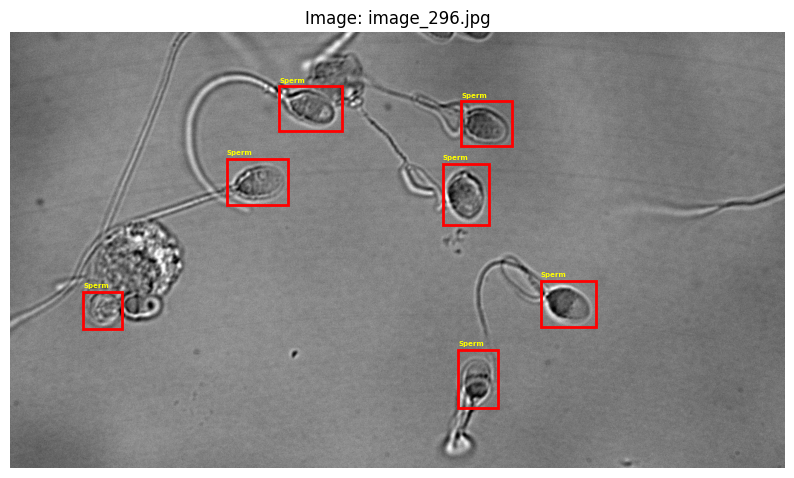

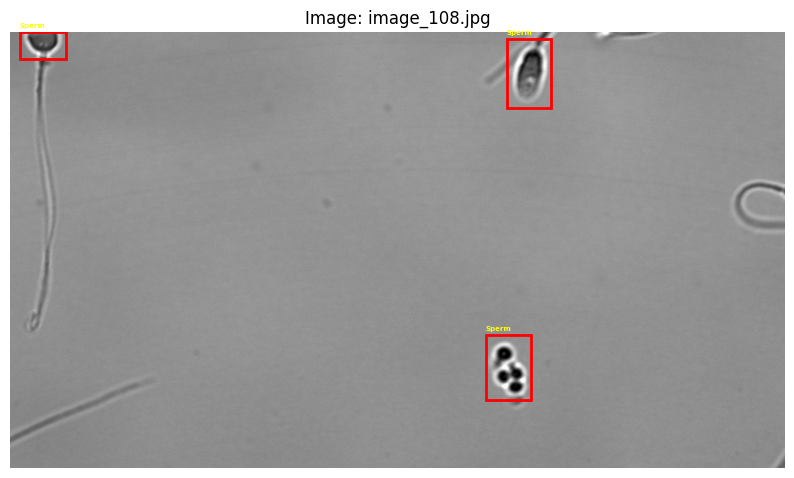

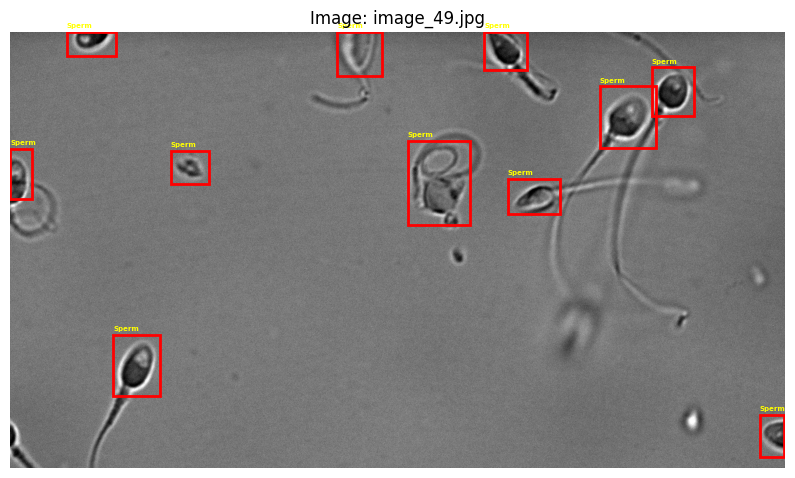

In [ ]:
import pandas as pd
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load your CSV into a DataFrame
output_df = pd.read_csv('/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_val_predictions.csv')

# Directory containing images
images_dir = '/content/drive/MyDrive/data_images/vott-csv-export'  # adjust this if needed

# --- Show random output images with boxes ---
def show_random_outputs(image_dir, output_df, n=3):
    sample_images = random.sample(output_df['image'].unique().tolist(), n)

    for img_name in sample_images:
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(img)

        boxes = output_df[output_df['image'] == img_name]
        for _, row in boxes.iterrows():
            rect = patches.Rectangle(
                (row['xmin'], row['ymin']),
                row['xmax'] - row['xmin'],
                row['ymax'] - row['ymin'],
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(row['xmin'], row['ymin'] - 10, f"Sperm", color='yellow', fontsize=5, weight='bold')

        plt.title(f"Image: {img_name}")
        plt.axis('off')
        plt.show()

# --- Run the function ---
show_random_outputs(images_dir, output_df, n=3)


In [8]:
import pandas as pd
import os
import cv2
from tqdm import tqdm

# === CONFIG ===
csv_path = '/content/drive/MyDrive/data_images/vott-csv-export/sorted_output_file.csv'  # CSV file with YOLO predictions
images_dir = '/content/drive/MyDrive/data_images/yolo_dataset/images/train'            # Original images folder
output_dir = '/content/drive/MyDrive/data_images/csv/yolo_sam/train'   # Output folder for cropped images
os.makedirs(output_dir, exist_ok=True)

# === LOAD CSV ===
df = pd.read_csv(csv_path)

# Add sub-index per image for unique cropping numbering
df['sub_index'] = df.groupby('image').cumcount()

# === CROP AND SAVE ===
for idx, row in tqdm(df.iterrows(), total=len(df), desc='Cropping images'):
    image_path = os.path.join(images_dir, row['image'])

    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read {image_path}")
        continue

    # Get box coordinates
    xmin, ymin, xmax, ymax = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])

    # Crop the region
    crop = image[ymin:ymax, xmin:xmax]

    # Build unique filename for each crop
    base_name = os.path.splitext(row['image'])[0]
    crop_name = f"{base_name}_{row['sub_index']}.jpg"
    crop_path = os.path.join(output_dir, crop_name)

    # Save cropped image
    cv2.imwrite(crop_path, crop)

print(f"Saved all cropped images to: {output_dir}")


Cropping images:   1%|          | 14/2225 [00:13<14:53,  2.47it/s]

Cropping images:   3%|▎         | 56/2225 [00:24<07:53,  4.58it/s]

Cropping images:  12%|█▏        | 266/2225 [00:59<07:52,  4.15it/s]

Cropping images:  18%|█▊        | 395/2225 [01:16<06:56,  4.39it/s]

Cropping images:  21%|██        | 461/2225 [01:31<07:12,  4.08it/s]

Cropping images:  25%|██▌       | 566/2225 [01:53<06:07,  4.52it/s]

Cropping images:  28%|██▊       | 621/2225 [02:03<06:26,  4.15it/s]

Cropping images:  40%|███▉      | 883/2225 [03:03<05:40,  3.94it/s]

Cropping images:  47%|████▋     | 1046/2225 [03:42<04:18,  4.56it/s]

Cropping images:  51%|█████     | 1129/2225 [03:58<05:01,  3.63it/s]

Cropping images:  53%|█████▎    | 1186/2225 [04:10<03:59,  4.34it/s]

Cropping images:  54%|█████▍    | 1196/2225 [04:12<03:13,  5.31it/s]

Cropping images:  57%|█████▋    | 1262/2225 [04:27<04:14,  3.78it/s]

Cropping images:  57%|█████▋    | 1265/2225 [04:28<03:50,  4.17it/s]

Cropping images:  58%|█████▊    | 1295/2225 [04:37<04:30,  3.44it/s]

Cropping images:  59%|█████▉    | 1312/2225 [04:40<04:10,  3.64it/s]

Cropping images:  59%|█████▉    | 1322/2225 [04:43<04:23,  3.43it/s]

Cropping images:  60%|██████    | 1341/2225 [04:47<04:01,  3.66it/s]

Cropping images:  61%|██████    | 1356/2225 [04:51<03:29,  4.14it/s]

Cropping images:  61%|██████▏   | 1368/2225 [04:54<03:20,  4.26it/s]

Cropping images:  63%|██████▎   | 1393/2225 [04:57<02:56,  4.72it/s]

Cropping images:  63%|██████▎   | 1403/2225 [04:59<02:25,  5.66it/s]

Cropping images:  64%|██████▎   | 1418/2225 [05:01<02:50,  4.74it/s]

Cropping images:  65%|██████▌   | 1453/2225 [05:06<02:56,  4.38it/s]

Cropping images:  68%|██████▊   | 1522/2225 [05:25<03:17,  3.56it/s]

Cropping images:  70%|██████▉   | 1557/2225 [05:32<02:26,  4.55it/s]

Cropping images:  71%|███████▏  | 1586/2225 [05:39<02:53,  3.69it/s]

Cropping images:  73%|███████▎  | 1622/2225 [05:46<02:01,  4.97it/s]

Cropping images:  74%|███████▎  | 1639/2225 [05:49<01:54,  5.13it/s]

Cropping images:  77%|███████▋  | 1712/2225 [06:07<01:56,  4.39it/s]

Cropping images:  78%|███████▊  | 1741/2225 [06:12<01:47,  4.51it/s]

Cropping images:  80%|████████  | 1790/2225 [06:26<02:37,  2.76it/s]

Cropping images:  81%|████████  | 1795/2225 [06:27<01:28,  4.84it/s]

Cropping images:  81%|████████▏ | 1809/2225 [06:30<01:52,  3.71it/s]

Cropping images:  82%|████████▏ | 1829/2225 [06:37<01:41,  3.90it/s]

Cropping images:  82%|████████▏ | 1833/2225 [06:38<01:34,  4.13it/s]

Cropping images:  83%|████████▎ | 1845/2225 [06:40<02:13,  2.84it/s]

Cropping images:  84%|████████▍ | 1867/2225 [06:48<01:44,  3.43it/s]

Cropping images:  84%|████████▍ | 1874/2225 [06:50<01:21,  4.29it/s]

Cropping images:  85%|████████▍ | 1888/2225 [06:55<01:53,  2.97it/s]

Cropping images:  85%|████████▌ | 1895/2225 [06:56<01:22,  4.01it/s]

Cropping images:  87%|████████▋ | 1940/2225 [07:09<01:05,  4.36it/s]

Cropping images:  90%|████████▉ | 1993/2225 [07:15<00:56,  4.09it/s]

Cropping images:  92%|█████████▏| 2036/2225 [07:25<00:47,  4.00it/s]

Cropping images:  94%|█████████▎| 2084/2225 [07:37<00:29,  4.81it/s]

Cropping images:  95%|█████████▍| 2112/2225 [07:41<00:30,  3.71it/s]

Cropping images:  96%|█████████▌| 2131/2225 [07:44<00:22,  4.27it/s]

Cropping images: 100%|██████████| 2225/2225 [08:05<00:00,  4.58it/s]

Saved all cropped images to: /content/drive/MyDrive/data_images/csv/yolo_sam/train


In [9]:
import pandas as pd
import os
import cv2
from tqdm import tqdm

# === CONFIG ===
csv_path = '/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_sam_predictions.csv'              # CSV file with YOLO predictions
images_dir = '/content/drive/MyDrive/data_images/yolo_dataset/images/val'           # Folder where original images are stored
output_dir = '/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam'                  # Folder to save cropped images
os.makedirs(output_dir, exist_ok=True)

# === LOAD CSV ===
df = pd.read_csv(csv_path)

# === CROP AND SAVE ===
for idx, row in tqdm(df.iterrows(), total=len(df), desc='Cropping images'):
    image_path = os.path.join(images_dir, row['image'])

    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read {image_path}")
        continue

    # Get box coordinates
    xmin, ymin, xmax, ymax = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])

    # Crop the region
    crop = image[ymin:ymax, xmin:xmax]

    # Build a unique filename for each crop
    base_name = os.path.splitext(row['image'])[0]
    crop_name = f"{base_name}_{idx}.jpg"
    crop_path = os.path.join(output_dir, crop_name)

    # Save cropped image
    cv2.imwrite(crop_path, crop)

print(f"Saved all cropped images to: {output_dir}")


Cropping images:  12%|█▏        | 281/2385 [00:00<00:02, 866.42it/s]

Cropping images:  49%|████▉     | 1163/2385 [00:00<00:00, 2223.98it/s]

Cropping images:  74%|███████▍  | 1767/2385 [00:00<00:00, 2628.44it/s]

Cropping images: 100%|██████████| 2385/2385 [02:20<00:00, 17.03it/s]

Saved all cropped images to: /content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam


In [10]:
import os
import cv2
import numpy as np
import pandas as pd

# Paths
base_dir = '/content/drive/MyDrive/data_images/yolo_dataset'  # Base path for images
csv_path = '/content/drive/MyDrive/data_images/vott-csv-export/sorted_output_file.csv'  # CSV file path
output_dir = '/content/drive/MyDrive/data_images/yolo_dataset'  # Output directory path

# Create output directory if not exists
os.makedirs(output_dir, exist_ok=True)

# Read CSV annotations
annotations = pd.read_csv(csv_path)

# List to store results
dfi_values = []

# Loop through each annotation
for idx, row in annotations.iterrows():
    image_name, xmin, ymin, xmax, ymax = row['image'], row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Remove underscore from image name (e.g., image_1 → image1)
    image_name = image_name.replace('_', '')

    # Remove file extension if present
    image_name = os.path.splitext(image_name)[0]

    # Build paths with correct capitalization in folder names
    green_train_path = os.path.join(base_dir, 'Green', 'train', f"{image_name}.jpg")
    red_train_path = os.path.join(base_dir, 'Red', 'train', f"{image_name}.jpg")

    green_val_path = os.path.join(base_dir, 'Green', 'val', f"{image_name}.jpg")
    red_val_path = os.path.join(base_dir, 'Red', 'val', f"{image_name}.jpg")

    print(f"Looking for:\n  Green Train Path: {green_train_path}\n  Red Train Path: {red_train_path}")
    print(f"  Green Val Path: {green_val_path}\n  Red Val Path: {red_val_path}")

    # Check if files exist in train or val
    if os.path.exists(green_train_path) and os.path.exists(red_train_path):
        green_image_path = green_train_path
        red_image_path = red_train_path
        dataset = 'train'
    elif os.path.exists(green_val_path) and os.path.exists(red_val_path):
        green_image_path = green_val_path
        red_image_path = red_val_path
        dataset = 'val'
    else:
        print(f"❌ Image pair not found for {image_name}")
        continue

    # Load images in grayscale
    green_image = cv2.imread(green_image_path, cv2.IMREAD_GRAYSCALE)
    red_image = cv2.imread(red_image_path, cv2.IMREAD_GRAYSCALE)

    if green_image is None or red_image is None:
        print(f"❌ Failed to load images for {image_name}")
        continue

    # Convert coordinates to int (slice indices must be integers)
    xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])

    # Crop the region of interest
    green_crop = green_image[ymin:ymax, xmin:xmax]
    red_crop = red_image[ymin:ymax, xmin:xmax]

    # Sum pixel intensities in cropped region
    green_sum = np.sum(green_crop)
    red_sum = np.sum(red_crop)

    # Calculate DFI (avoid division by zero)
    dfi = (red_sum / (green_sum + red_sum)) if (green_sum + red_sum) > 0 else 0

    # Store results
    dfi_values.append((image_name, xmin, ymin, xmax, ymax, dfi, dataset))
    print(f"✅ Processed {image_name} in {dataset}: DFI = {dfi:.3f}")

# Save results to CSV
dfi_df = pd.DataFrame(dfi_values, columns=['Image Name', 'xmin', 'ymin', 'xmax', 'ymax', 'DFI', 'Dataset'])
dfi_df.to_csv(os.path.join(output_dir, 'DFI_results_all.csv'), index=False)

print("\nDFI calculation completed and saved to DFI_results.csv")


Streaming output truncated to the last 5000 lines.
Looking for:
  Green Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/train/image116.jpg
  Red Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Red/train/image116.jpg
  Green Val Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/val/image116.jpg
  Red Val Path: /content/drive/MyDrive/data_images/yolo_dataset/Red/val/image116.jpg
✅ Processed image116 in train: DFI = 0.420
Looking for:
  Green Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/train/image117.jpg
  Red Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Red/train/image117.jpg
  Green Val Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/val/image117.jpg
  Red Val Path: /content/drive/MyDrive/data_images/yolo_dataset/Red/val/image117.jpg
✅ Processed image117 in val: DFI = 0.027
Looking for:
  Green Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/train/image117.jpg
  Red Train Path: /co

In [11]:
import os
import cv2
import numpy as np
import pandas as pd

# Paths
base_dir = '/content/drive/MyDrive/data_images/yolo_dataset'  # Base path for images
csv_path = '/content/drive/MyDrive/data_images/yolo_dataset/images/yolo_val_predictions.csv'  # CSV file path
output_dir = '/content/drive/MyDrive/data_images/yolo_dataset'  # Output directory path

# Create output directory if not exists
os.makedirs(output_dir, exist_ok=True)

# Read CSV annotations
annotations = pd.read_csv(csv_path)

# List to store results
dfi_values = []

# Loop through each annotation
for idx, row in annotations.iterrows():
    image_name, xmin, ymin, xmax, ymax = row['image'], row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Remove underscore from image name (e.g., image_1 → image1)
    image_name = image_name.replace('_', '')

    # Remove file extension if present
    image_name = os.path.splitext(image_name)[0]

    # Build paths with correct capitalization in folder names
    green_train_path = os.path.join(base_dir, 'Green', 'train', f"{image_name}.jpg")
    red_train_path = os.path.join(base_dir, 'Red', 'train', f"{image_name}.jpg")

    green_val_path = os.path.join(base_dir, 'Green', 'val', f"{image_name}.jpg")
    red_val_path = os.path.join(base_dir, 'Red', 'val', f"{image_name}.jpg")

    print(f"Looking for:\n  Green Train Path: {green_train_path}\n  Red Train Path: {red_train_path}")
    print(f"  Green Val Path: {green_val_path}\n  Red Val Path: {red_val_path}")

    # Check if files exist in train or val
    if os.path.exists(green_train_path) and os.path.exists(red_train_path):
        green_image_path = green_train_path
        red_image_path = red_train_path
        dataset = 'train'
    elif os.path.exists(green_val_path) and os.path.exists(red_val_path):
        green_image_path = green_val_path
        red_image_path = red_val_path
        dataset = 'val'
    else:
        print(f"❌ Image pair not found for {image_name}")
        continue

    # Load images in grayscale
    green_image = cv2.imread(green_image_path, cv2.IMREAD_GRAYSCALE)
    red_image = cv2.imread(red_image_path, cv2.IMREAD_GRAYSCALE)

    if green_image is None or red_image is None:
        print(f"❌ Failed to load images for {image_name}")
        continue

    # Convert coordinates to int (slice indices must be integers)
    xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])

    # Crop the region of interest
    green_crop = green_image[ymin:ymax, xmin:xmax]
    red_crop = red_image[ymin:ymax, xmin:xmax]

    # Sum pixel intensities in cropped region
    green_sum = np.sum(green_crop)
    red_sum = np.sum(red_crop)

    # Calculate DFI (avoid division by zero)
    dfi = (red_sum / (green_sum + red_sum)) if (green_sum + red_sum) > 0 else 0

    # Store results
    dfi_values.append((image_name, xmin, ymin, xmax, ymax, dfi, dataset))
    print(f"✅ Processed {image_name} in {dataset}: DFI = {dfi:.3f}")

# Save results to CSV
dfi_df = pd.DataFrame(dfi_values, columns=['Image Name', 'xmin', 'ymin', 'xmax', 'ymax', 'DFI', 'Dataset'])
dfi_df.to_csv(os.path.join(output_dir, 'DFI_results_yolo_val.csv'), index=False)

print("\nDFI calculation completed and saved to DFI_results.csv")


Looking for:
  Green Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/train/image100.jpg
  Red Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Red/train/image100.jpg
  Green Val Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/val/image100.jpg
  Red Val Path: /content/drive/MyDrive/data_images/yolo_dataset/Red/val/image100.jpg
✅ Processed image100 in val: DFI = 0.398
Looking for:
  Green Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/train/image100.jpg
  Red Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Red/train/image100.jpg
  Green Val Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/val/image100.jpg
  Red Val Path: /content/drive/MyDrive/data_images/yolo_dataset/Red/val/image100.jpg
✅ Processed image100 in val: DFI = 0.223
Looking for:
  Green Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Green/train/image100.jpg
  Red Train Path: /content/drive/MyDrive/data_images/yolo_dataset/Red/trai

In [18]:
import pandas as pd

# --- File paths ---
input_csv = '/content/drive/MyDrive/data_images/yolo_dataset/DFI_results_all.csv'         # Input CSV file with a 'Dataset' column
train_csv = '/content/drive/MyDrive/data_images/csv/yolo_sam/train_all.csv'         # Output CSV for training data
val_csv = '/content/drive/MyDrive/data_images/csv/yolo_sam/val_all.csv'             # Output CSV for validation data

# --- Read the input CSV ---
df = pd.read_csv(input_csv)

# --- Check if 'Dataset' column exists ---
if 'Dataset' not in df.columns:
    raise ValueError("❌ The 'Dataset' column is missing from the input CSV!")

# --- Filter rows for training and validation ---
train_df = df[df['Dataset'].str.lower() == 'train']
val_df = df[df['Dataset'].str.lower() == 'val']

# --- Save to separate CSV files ---
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)

print(f"✅ Saved {len(train_df)} training rows to: {train_csv}")
print(f"✅ Saved {len(val_df)} validation rows to: {val_csv}")


✅ Saved 1775 training rows to: /content/drive/MyDrive/data_images/csv/yolo_sam/train_all.csv
✅ Saved 450 validation rows to: /content/drive/MyDrive/data_images/csv/yolo_sam/val_all.csv


In [26]:
import pandas as pd

# --- File paths ---
input_csv = '/content/drive/MyDrive/data_images/yolo_dataset/DFI_results_yolo_val.csv'         # Input CSV file with a 'Dataset' column
train_csv = '/content/drive/MyDrive/data_images/csv/yolo_sam/train_yolo_sam.csv'         # Output CSV for training data
val_csv = '/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam.csv'             # Output CSV for validation data

# --- Read the input CSV ---
df = pd.read_csv(input_csv)

# --- Check if 'Dataset' column exists ---
if 'Dataset' not in df.columns:
    raise ValueError("❌ The 'Dataset' column is missing from the input CSV!")

# --- Filter rows for training and validation ---
train_df = df[df['Dataset'].str.lower() == 'train']
val_df = df[df['Dataset'].str.lower() == 'val']

# --- Save to separate CSV files ---
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)

print(f"✅ Saved {len(train_df)} training rows to: {train_csv}")
print(f"✅ Saved {len(val_df)} validation rows to: {val_csv}")


✅ Saved 0 training rows to: /content/drive/MyDrive/data_images/csv/yolo_sam/train_yolo_sam.csv
✅ Saved 495 validation rows to: /content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam.csv


In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from tqdm import tqdm

import torch
import timm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

# For EfficientNet
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet


In [19]:
import pandas as pd
import re
import os

# === Paths ===
csv_path = '/content/drive/MyDrive/data_images/csv/yolo_sam/train_all.csv'
output_csv_path = '/content/drive/MyDrive/data_images/csv/yolo_sam/train_all.csv'

# === Load CSV ===
df = pd.read_csv(csv_path)

# Convert "image1" to "image_1"
df['Image Name'] = df['Image Name'].apply(lambda x: re.sub(r'^image(\d+)', r'image_\1', x))

# Add a sub-index to create unique names like image_1_0, image_1_1, ...
df['sub_index'] = df.groupby('Image Name').cumcount()

# Create a new column with the new image names
df['Image Name'] = df['Image Name'] + '_' + df['sub_index'].astype(str) + '.jpg'

# Save updated CSV
df.to_csv(output_csv_path, index=False)

print(f"✅ Image names updated and saved to: {output_csv_path}")


✅ Image names updated and saved to: /content/drive/MyDrive/data_images/csv/yolo_sam/train_all.csv


In [27]:
import pandas as pd

# Path to your CSV file
csv_path = '/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam.csv'
df = pd.read_csv(csv_path)

# Reset index to have a numeric index column
df.reset_index(inplace=True)

# Add a global counter starting from 1890 instead of 0
start_num = 1890
df['Image Name'] = df.apply(lambda row: f"{row['Image Name']}_{row['index'] + start_num}", axis=1)

# Drop the temporary index column
df.drop(columns=['index'], inplace=True)

# Save the modified CSV (optional)
df.to_csv('/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam.csv', index=False)

print("Image names updated successfully, starting numbering from 1890.")


Image names updated successfully, starting numbering from 1890.


In [22]:
print(df.columns)
print(df.head())

Index(['Image Name', 'xmin', 'ymin', 'xmax', 'ymax', 'DFI', 'Dataset'], dtype='object')
      Image Name  xmin  ymin  xmax  ymax       DFI Dataset
0  image100_1890   205   222   317   365  0.397795     val
1  image100_1891  1040   211  1169   313  0.223206     val
2  image100_1892   530   147   645   262  0.397238     val
3  image100_1893   497     0   624   152  0.386313     val
4  image100_1894   704   839   858   944  0.483214     val


In [9]:
import pandas as pd
import os
import re

# === Paths ===
csv_path_train = '/content/drive/MyDrive/data_images/csv/yolo_sam/train_all.csv'
csv_path_val = '/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam.csv'
train_dir = '/content/drive/MyDrive/data_images/csv/yolo_sam/train'
val_dir = '/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam'

# === Function to find actual image file with any common extension ===
def find_existing_filename(base_name, folder_path):
    for ext in ['.jpg', '.jpeg', '.png']:
        candidate = os.path.join(folder_path, base_name + ext)
        if os.path.isfile(candidate):
            return os.path.basename(candidate)
    return None

# === Function to filter dataframe by actual existing files ===
def filter_existing_images_dynamic(df_subset, folder_path):
    valid_rows = []
    for idx, row in df_subset.iterrows():
        base = row['Image Name']
        candidate = os.path.join(folder_path, base)
        if os.path.isfile(candidate):
            row['filename'] = base
            valid_rows.append(row)
        else:
            print(f"Warning: Image not found for base name '{base}' in {folder_path}")
    return pd.DataFrame(valid_rows)

# === Process train CSV ===
df_train = pd.read_csv(csv_path_train)
df_train_filtered = filter_existing_images_dynamic(df_train, train_dir)
train_csv_out = '/content/drive/MyDrive/data_images/yolo_dataset/images/train_all.csv'
df_train_filtered.to_csv(train_csv_out, index=False)

# === Process val CSV ===
df_val = pd.read_csv(csv_path_val)
df_val_filtered = filter_existing_images_dynamic(df_val, val_dir)
val_csv_out = '/content/drive/MyDrive/data_images/yolo_dataset/val_yolo_sam.csv'
df_val_filtered.to_csv(val_csv_out, index=False)

# === Final Output ===
print(f"Filtered Train samples: {len(df_train_filtered)} -> Saved to {train_csv_out}")
print(f"Filtered Val samples: {len(df_val_filtered)}   -> Saved to {val_csv_out}")

# === Preview ===
print("\nSample filtered train rows:")
print(df_train_filtered.head())

print("\nSample filtered val rows:")
print(df_val_filtered.head())


Filtered Train samples: 1775 -> Saved to /content/drive/MyDrive/data_images/yolo_dataset/images/train_all.csv
Filtered Val samples: 0   -> Saved to /content/drive/MyDrive/data_images/yolo_dataset/val_yolo_sam.csv

Sample filtered train rows:
      Image Name  xmin  ymin  xmax  ymax       DFI Dataset  sub_index  \
0  image_1_0.jpg  1371   434  1587   677  0.245711   train          0   
1  image_1_1.jpg   654    92   785   267  0.196540   train          1   
2  image_1_2.jpg   658   447   815   635  0.110722   train          2   
3  image_1_3.jpg    55   372   358   604  0.128899   train          3   
4  image_2_0.jpg   610   862   735  1024  0.088483   train          0   

        filename  
0  image_1_0.jpg  
1  image_1_1.jpg  
2  image_1_2.jpg  
3  image_1_3.jpg  
4  image_2_0.jpg  

Sample filtered val rows:
Empty DataFrame
Columns: []
Index: []


In [20]:
import pandas as pd
import re

# Load CSV
csv_path = '/content/drive/MyDrive/data_images/csv/yolo_sam/train_all.csv'
df = pd.read_csv(csv_path)

# Ensure 'filename' column exists
if 'filename' not in df.columns:
   def fix_filename(name):
    fixed = re.sub(r'^image(\d+)', r'image_\1', name)
    if not fixed.endswith('.jpg'):
        fixed += '.jpg'
    return fixed
df['filename'] = df['Image Name']


# Create binary DFI classification (low < 0.1, high > 0.15)
def classify_dfi(dfi):
    try:
        dfi = float(dfi)
    except:
        return None
    if dfi < 0.08:
        return 'low'
    elif dfi > 0.11:
        return 'high'
    else:
        return None  # discard values between 0.1 and 0.15

# Apply classification and drop intermediate values
df['dfi_class'] = df['DFI'].apply(classify_dfi)
df = df.dropna(subset=['dfi_class'])

# Separate train and val sets
df_train = df[df['Dataset'] == 'train']
df_val = df[df['Dataset'] == 'val']

# Count samples per class for train
train_counts = df_train['dfi_class'].value_counts()
print("✅ Number of samples per DFI class in TRAIN set:")
print(train_counts)

print("\n---------------------------\n")

# Count samples per class for val
val_counts = df_val['dfi_class'].value_counts()
print("✅ Number of samples per DFI class in VAL set:")
print(val_counts)

# Optional: Save the updated CSV
updated_csv_path = '/content/drive/MyDrive/data_images/csv/yolo_sam/train_all.csv'
df.to_csv(updated_csv_path, index=False)


✅ Number of samples per DFI class in TRAIN set:
dfi_class
low     714
high    710
Name: count, dtype: int64

---------------------------

✅ Number of samples per DFI class in VAL set:
Series([], Name: count, dtype: int64)


In [28]:
import pandas as pd
import re

# Load CSV
csv_path = '/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam.csv'
df = pd.read_csv(csv_path)

# Ensure 'filename' column exists
if 'filename' not in df.columns:
    def fix_filename(name):
        fixed = re.sub(r'^image(\d+)', r'image_\1', name)
        return fixed + '.jpg'
    df['filename'] = df['Image Name'].apply(fix_filename)

# Create binary DFI classification (low < 0.1, high > 0.15)
def classify_dfi(dfi):
    try:
        dfi = float(dfi)
    except:
        return None
    if dfi < 0.08:
        return 'low'
    elif dfi > 0.11:
        return 'high'
    else:
        return None  # discard values between 0.1 and 0.15

# Apply classification and drop intermediate values
df['dfi_class'] = df['DFI'].apply(classify_dfi)
df = df.dropna(subset=['dfi_class'])

# Separate train and val sets
df_train = df[df['Dataset'] == 'train']
df_val = df[df['Dataset'] == 'val']

# Count samples per class for train
train_counts = df_train['dfi_class'].value_counts()
print("✅ Number of samples per DFI class in TRAIN set:")
print(train_counts)

print("\n---------------------------\n")

# Count samples per class for val
val_counts = df_val['dfi_class'].value_counts()
print("✅ Number of samples per DFI class in VAL set:")
print(val_counts)

# Optional: Save the updated CSV
updated_csv_path = '/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam.csv'
df.to_csv(updated_csv_path, index=False)


✅ Number of samples per DFI class in TRAIN set:
Series([], Name: count, dtype: int64)

---------------------------

✅ Number of samples per DFI class in VAL set:
dfi_class
high    224
low     178
Name: count, dtype: int64


In [29]:
# Paths to CSVs and image directories
train_csv_path = '/content/drive/MyDrive/data_images/csv/yolo_sam/train_all.csv'
val_csv_path = '/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam.csv'
train_img_dir = '/content/drive/MyDrive/data_images/csv/yolo_sam/train'
val_img_dir ='/content/drive/MyDrive/data_images/csv/yolo_sam/val_yolo_sam'

# Load dataframes
df_train = pd.read_csv(train_csv_path)
df_val = pd.read_csv(val_csv_path)

In [30]:
import random
# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)


In [31]:
# Dataset class
class DfiDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'low': 0,'high': 1}
        self.df['label'] = self.df['dfi_class'].map(self.label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, row['label']


In [32]:
# Hyperparameters
dropout_rate = 0.6
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-4  # for optimizer regularization
early_stopping_patience = 10


In [33]:
# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [34]:
# Create datasets and dataloaders
train_dataset = DfiDataset(df_train, train_img_dir, transform=train_transform)
val_dataset = DfiDataset(df_val, val_img_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [35]:
# Extract all labels from the training loader
labels_train = []

for _, labels in train_loader:
    labels_train.extend(labels.numpy())  # or labels.cpu().numpy() if on GPU


In [36]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")


Train dataset size: 1424
Validation dataset size: 402


In [37]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from efficientnet_pytorch import EfficientNet
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
dropout_rate = 0.6
learning_rate = 1e-4
weight_decay = 1e-5
num_epochs = 100
early_stopping_patience = 20
num_classes = 2

# Define EfficientNet-B0 model with dropout
class EfficientNetB0Classifier(nn.Module):
    def __init__(self, dropout_rate=0.6, num_classes=2):
        super().__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')
        in_features = self.base_model._fc.in_features
        self.base_model._fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

model = EfficientNetB0Classifier(dropout_rate=dropout_rate, num_classes=num_classes).to(device)

# Compute class weights from training labels (labels_train must be provided)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=20, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss >= self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True)

# Training epoch
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return epoch_loss, acc, prec, rec, f1

# Validation epoch
def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return epoch_loss, acc, prec, rec, f1

# Metric lists
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []

# Training loop
best_val_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1 = validate_epoch(model, val_loader, criterion)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train - Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✔️ Best model saved at epoch {epoch} with val_loss: {val_loss:.4f}")

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_precisions.append(train_prec)
    val_precisions.append(val_prec)
    train_recalls.append(train_rec)
    val_recalls.append(val_rec)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    # Scheduler and early stopping
    scheduler.step(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("⏹️ Early stopping triggered.")
        break


Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or 

Epoch 1 | Train Loss: 0.6106, Val Loss: 0.6601
Train - Acc: 0.6664, Prec: 0.6665, Recall: 0.6664, F1: 0.6664
Val   - Acc: 0.5796, Prec: 0.5784, Recall: 0.5796, F1: 0.5182
✔️ Best model saved at epoch 1 with val_loss: 0.6601


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2 | Train Loss: 0.5307, Val Loss: 0.6327
Train - Acc: 0.7654, Prec: 0.7659, Recall: 0.7654, F1: 0.7654
Val   - Acc: 0.6269, Prec: 0.6985, Recall: 0.6269, F1: 0.5572
✔️ Best model saved at epoch 2 with val_loss: 0.6327


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3 | Train Loss: 0.4752, Val Loss: 0.5963
Train - Acc: 0.7879, Prec: 0.7888, Recall: 0.7879, F1: 0.7878
Val   - Acc: 0.6866, Prec: 0.7467, Recall: 0.6866, F1: 0.6488
✔️ Best model saved at epoch 3 with val_loss: 0.5963


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4 | Train Loss: 0.4560, Val Loss: 0.5888
Train - Acc: 0.7816, Prec: 0.7822, Recall: 0.7816, F1: 0.7815
Val   - Acc: 0.7040, Prec: 0.7597, Recall: 0.7040, F1: 0.6726
✔️ Best model saved at epoch 4 with val_loss: 0.5888


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5 | Train Loss: 0.4195, Val Loss: 0.5874
Train - Acc: 0.8083, Prec: 0.8083, Recall: 0.8083, F1: 0.8083
Val   - Acc: 0.7139, Prec: 0.7599, Recall: 0.7139, F1: 0.6879
✔️ Best model saved at epoch 5 with val_loss: 0.5874


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6 | Train Loss: 0.4261, Val Loss: 0.5693
Train - Acc: 0.8146, Prec: 0.8146, Recall: 0.8146, F1: 0.8146
Val   - Acc: 0.7313, Prec: 0.7698, Recall: 0.7313, F1: 0.7111
✔️ Best model saved at epoch 6 with val_loss: 0.5693


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7 | Train Loss: 0.3963, Val Loss: 0.5555
Train - Acc: 0.8244, Prec: 0.8245, Recall: 0.8244, F1: 0.8244
Val   - Acc: 0.7363, Prec: 0.7735, Recall: 0.7363, F1: 0.7173
✔️ Best model saved at epoch 7 with val_loss: 0.5555


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8 | Train Loss: 0.3602, Val Loss: 0.5688
Train - Acc: 0.8455, Prec: 0.8455, Recall: 0.8455, F1: 0.8455
Val   - Acc: 0.7512, Prec: 0.7753, Recall: 0.7512, F1: 0.7383
EarlyStopping counter: 1 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9 | Train Loss: 0.3622, Val Loss: 0.5307
Train - Acc: 0.8427, Prec: 0.8428, Recall: 0.8427, F1: 0.8427
Val   - Acc: 0.7612, Prec: 0.7812, Recall: 0.7612, F1: 0.7505
✔️ Best model saved at epoch 9 with val_loss: 0.5307


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10 | Train Loss: 0.3200, Val Loss: 0.4690
Train - Acc: 0.8603, Prec: 0.8603, Recall: 0.8603, F1: 0.8602
Val   - Acc: 0.8060, Prec: 0.8124, Recall: 0.8060, F1: 0.8023
✔️ Best model saved at epoch 10 with val_loss: 0.4690


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11 | Train Loss: 0.2856, Val Loss: 0.4589
Train - Acc: 0.8834, Prec: 0.8835, Recall: 0.8834, F1: 0.8834
Val   - Acc: 0.8209, Prec: 0.8238, Recall: 0.8209, F1: 0.8188
✔️ Best model saved at epoch 11 with val_loss: 0.4589


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12 | Train Loss: 0.2832, Val Loss: 0.5404
Train - Acc: 0.8848, Prec: 0.8851, Recall: 0.8848, F1: 0.8848
Val   - Acc: 0.7935, Prec: 0.8055, Recall: 0.7935, F1: 0.7876
EarlyStopping counter: 1 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13 | Train Loss: 0.2807, Val Loss: 0.4853
Train - Acc: 0.8792, Prec: 0.8799, Recall: 0.8792, F1: 0.8792
Val   - Acc: 0.7886, Prec: 0.7954, Recall: 0.7886, F1: 0.7840
EarlyStopping counter: 2 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14 | Train Loss: 0.2417, Val Loss: 0.4937
Train - Acc: 0.9003, Prec: 0.9011, Recall: 0.9003, F1: 0.9002
Val   - Acc: 0.8134, Prec: 0.8158, Recall: 0.8134, F1: 0.8113
EarlyStopping counter: 3 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15 | Train Loss: 0.2269, Val Loss: 0.4614
Train - Acc: 0.9150, Prec: 0.9151, Recall: 0.9150, F1: 0.9150
Val   - Acc: 0.8308, Prec: 0.8314, Recall: 0.8308, F1: 0.8310
EarlyStopping counter: 4 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16 | Train Loss: 0.1899, Val Loss: 0.4829
Train - Acc: 0.9228, Prec: 0.9232, Recall: 0.9228, F1: 0.9227
Val   - Acc: 0.8209, Prec: 0.8206, Recall: 0.8209, F1: 0.8205
EarlyStopping counter: 5 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17 | Train Loss: 0.1898, Val Loss: 0.4897
Train - Acc: 0.9305, Prec: 0.9310, Recall: 0.9305, F1: 0.9305
Val   - Acc: 0.8259, Prec: 0.8257, Recall: 0.8259, F1: 0.8253
EarlyStopping counter: 6 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18 | Train Loss: 0.1829, Val Loss: 0.4817
Train - Acc: 0.9284, Prec: 0.9288, Recall: 0.9284, F1: 0.9284
Val   - Acc: 0.8383, Prec: 0.8387, Recall: 0.8383, F1: 0.8384
EarlyStopping counter: 7 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19 | Train Loss: 0.1716, Val Loss: 0.5090
Train - Acc: 0.9333, Prec: 0.9336, Recall: 0.9333, F1: 0.9333
Val   - Acc: 0.8134, Prec: 0.8131, Recall: 0.8134, F1: 0.8130
EarlyStopping counter: 8 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20 | Train Loss: 0.1749, Val Loss: 0.4769
Train - Acc: 0.9277, Prec: 0.9278, Recall: 0.9277, F1: 0.9277
Val   - Acc: 0.8284, Prec: 0.8291, Recall: 0.8284, F1: 0.8286
EarlyStopping counter: 9 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21 | Train Loss: 0.1463, Val Loss: 0.4763
Train - Acc: 0.9445, Prec: 0.9446, Recall: 0.9445, F1: 0.9445
Val   - Acc: 0.8259, Prec: 0.8311, Recall: 0.8259, F1: 0.8264
EarlyStopping counter: 10 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22 | Train Loss: 0.1674, Val Loss: 0.4717
Train - Acc: 0.9270, Prec: 0.9270, Recall: 0.9270, F1: 0.9270
Val   - Acc: 0.8234, Prec: 0.8238, Recall: 0.8234, F1: 0.8235
EarlyStopping counter: 11 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23 | Train Loss: 0.1409, Val Loss: 0.4907
Train - Acc: 0.9459, Prec: 0.9460, Recall: 0.9459, F1: 0.9459
Val   - Acc: 0.8308, Prec: 0.8321, Recall: 0.8308, F1: 0.8312
EarlyStopping counter: 12 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24 | Train Loss: 0.1459, Val Loss: 0.4882
Train - Acc: 0.9459, Prec: 0.9465, Recall: 0.9459, F1: 0.9459
Val   - Acc: 0.8209, Prec: 0.8222, Recall: 0.8209, F1: 0.8212
EarlyStopping counter: 13 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25 | Train Loss: 0.1421, Val Loss: 0.4900
Train - Acc: 0.9466, Prec: 0.9467, Recall: 0.9466, F1: 0.9466
Val   - Acc: 0.8209, Prec: 0.8227, Recall: 0.8209, F1: 0.8213
EarlyStopping counter: 14 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26 | Train Loss: 0.1306, Val Loss: 0.4935
Train - Acc: 0.9480, Prec: 0.9483, Recall: 0.9480, F1: 0.9480
Val   - Acc: 0.8159, Prec: 0.8183, Recall: 0.8159, F1: 0.8164
EarlyStopping counter: 15 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27 | Train Loss: 0.1419, Val Loss: 0.4983
Train - Acc: 0.9452, Prec: 0.9453, Recall: 0.9452, F1: 0.9452
Val   - Acc: 0.8259, Prec: 0.8277, Recall: 0.8259, F1: 0.8263
EarlyStopping counter: 16 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28 | Train Loss: 0.1306, Val Loss: 0.4987
Train - Acc: 0.9558, Prec: 0.9558, Recall: 0.9558, F1: 0.9558
Val   - Acc: 0.8284, Prec: 0.8299, Recall: 0.8284, F1: 0.8287
EarlyStopping counter: 17 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29 | Train Loss: 0.1326, Val Loss: 0.4941
Train - Acc: 0.9529, Prec: 0.9533, Recall: 0.9529, F1: 0.9529
Val   - Acc: 0.8358, Prec: 0.8376, Recall: 0.8358, F1: 0.8362
EarlyStopping counter: 18 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30 | Train Loss: 0.1273, Val Loss: 0.4890
Train - Acc: 0.9487, Prec: 0.9490, Recall: 0.9487, F1: 0.9487
Val   - Acc: 0.8308, Prec: 0.8314, Recall: 0.8308, F1: 0.8310
EarlyStopping counter: 19 out of 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31 | Train Loss: 0.1277, Val Loss: 0.4913
Train - Acc: 0.9473, Prec: 0.9474, Recall: 0.9473, F1: 0.9473
Val   - Acc: 0.8284, Prec: 0.8291, Recall: 0.8284, F1: 0.8286
EarlyStopping counter: 20 out of 20
⏹️ Early stopping triggered.


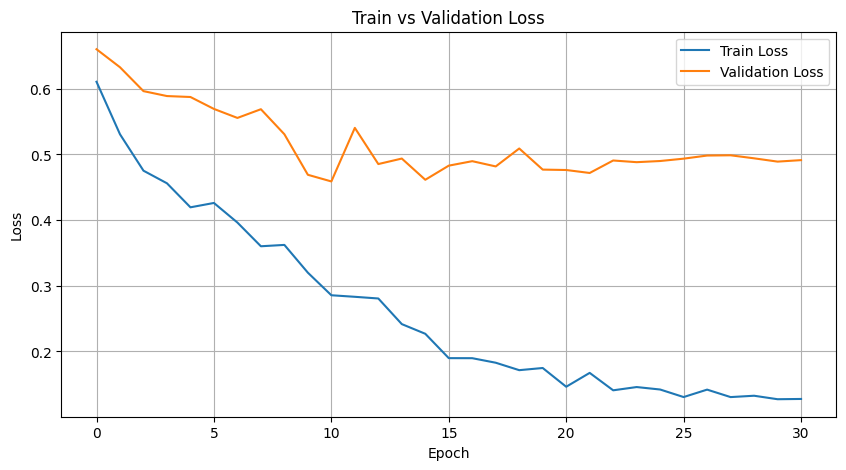


📊 Metrics per Epoch:
    Epoch  Train Acc  Val Acc  Train Prec  Val Prec  Train Recall  Val Recall  \
0       1     0.6664   0.5796      0.6665    0.5784        0.6664      0.5796   
1       2     0.7654   0.6269      0.7659    0.6985        0.7654      0.6269   
2       3     0.7879   0.6866      0.7888    0.7467        0.7879      0.6866   
3       4     0.7816   0.7040      0.7822    0.7597        0.7816      0.7040   
4       5     0.8083   0.7139      0.8083    0.7599        0.8083      0.7139   
5       6     0.8146   0.7313      0.8146    0.7698        0.8146      0.7313   
6       7     0.8244   0.7363      0.8245    0.7735        0.8244      0.7363   
7       8     0.8455   0.7512      0.8455    0.7753        0.8455      0.7512   
8       9     0.8427   0.7612      0.8428    0.7812        0.8427      0.7612   
9      10     0.8603   0.8060      0.8603    0.8124        0.8603      0.8060   
10     11     0.8834   0.8209      0.8835    0.8238        0.8834      0.8209   
11    

In [38]:
import matplotlib.pyplot as plt
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Metrics Table
results_df = pd.DataFrame({
    'Epoch': list(range(1, len(train_losses) + 1)),
    'Train Acc': train_accuracies,
    'Val Acc': val_accuracies,
    'Train Prec': train_precisions,
    'Val Prec': val_precisions,
    'Train Recall': train_recalls,
    'Val Recall': val_recalls,
    'Train F1': train_f1s,
    'Val F1': val_f1s
})
print("\n📊 Metrics per Epoch:")
print(results_df.round(4))
results_df.to_csv('/content/metrics_summary.csv', index=False)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


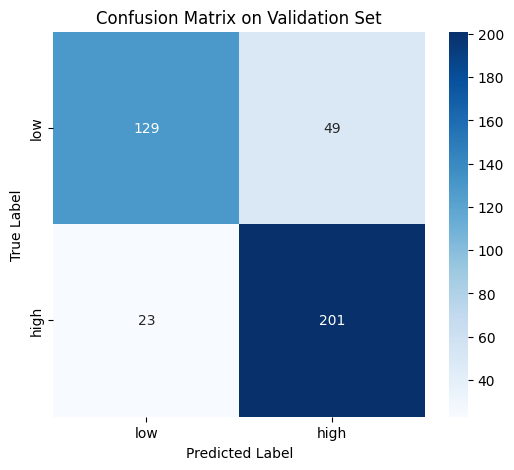

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Load best model weights
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Function to get predictions and true labels from the dataloader
def get_preds_and_labels(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    return all_preds, all_labels

# Get predictions and true labels from validation set
val_preds, val_labels = get_preds_and_labels(model, val_loader, device)

# Define class names (adjust if you have only 2 classes)
class_names = ['low', 'high']  # or ['low', 'medium', 'high']

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Validation Set")
plt.show()


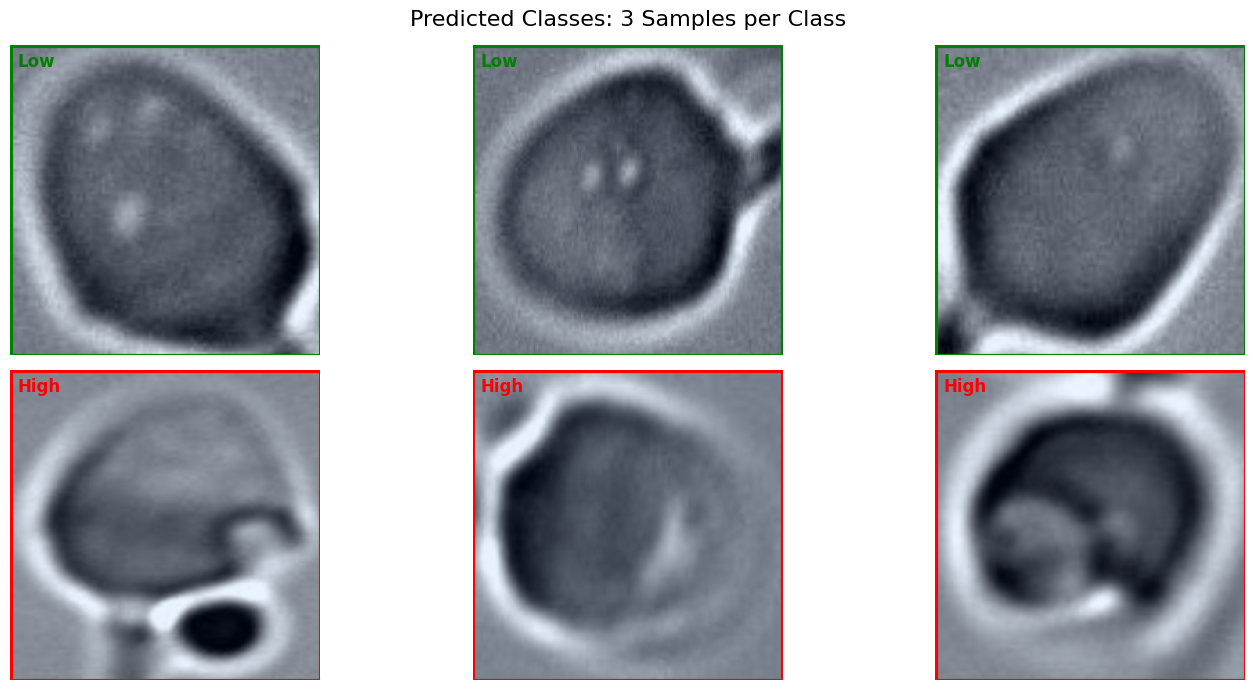

In [42]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from collections import defaultdict

# Load best model weights
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

# Mapping for class labels and colors
dfi_labels = {0: "Low", 1: "High"}
dfi_colors = {0: 'green', 1: 'red'}

# Storage for class-wise samples
class_samples = defaultdict(list)

# Gather samples until we have 3 for each class
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        for img, pred in zip(images.cpu(), preds):
            if len(class_samples[pred]) < 3:
                class_samples[pred].append(img)
        if all(len(class_samples[c]) >= 3 for c in dfi_labels):
            break

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 7))  # 2 rows (Low & High), 3 samples each
axes = axes.flatten()

idx = 0
for class_id in sorted(dfi_labels.keys()):
    for img in class_samples[class_id]:
        image = img.permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())

        color = dfi_colors[class_id]
        label_text = f"{dfi_labels[class_id]}"

        axes[idx].imshow(image)
        axes[idx].add_patch(plt.Rectangle((0, 0), image.shape[1], image.shape[0],
                                          edgecolor=color, facecolor='none', linewidth=3))
        axes[idx].text(5, 15, label_text, color=color, fontsize=12, weight='bold')
        axes[idx].axis('off')
        idx += 1

plt.suptitle("Predicted Classes: 3 Samples per Class", fontsize=16)
plt.tight_layout()
plt.show()
